In [21]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


# Decision Tree and Random Forest Regression

This notebook demonstrates Decision Tree and Random Forest regression using Scikit-Learn Pipelines to prevent data leakage.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from dataclasses import dataclass
from typing import Dict


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5


np.random.seed(RANDOM_STATE)

### 1️⃣ Load & Split Data

In [23]:
def load_data(
    file_path: str = "./data/dataset_processed.csv",
    target_column: str = "median_house_value",
    test_size: float = 0.2,
    random_state: int = 42
):
    """
    Loads dataset, splits into train and test sets.

    Returns:
        X_train, X_test, y_train, y_test
    """
    df = pd.read_csv(file_path)

    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

    return X_train, X_test, y_train, y_test

### 2️⃣ Preprocessing Pipeline
Using OneHotEncoder for categorical variables and Imputation for missing values.

In [24]:
# =====================================================
# 3. Preprocessing Builder
# =====================================================
def build_preprocessor(X: pd.DataFrame) -> ColumnTransformer:
	num_cols = X.select_dtypes(include=["int64", "float64"]).columns
	cat_cols = X.select_dtypes(include=["object"]).columns


	num_transformer = SimpleImputer(strategy="median")


	cat_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("onehot", OneHotEncoder(handle_unknown="ignore"))
	])


	return ColumnTransformer(
	transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols)
	]
)

In [25]:
@dataclass
class ModelConfig:
	name: str
	model: object

def get_models() -> Dict[str, ModelConfig]:
	return {
	"decision_tree": ModelConfig(
	name="Decision Tree",
	model=DecisionTreeRegressor(random_state=RANDOM_STATE)
	),
	"random_forest": ModelConfig(
	name="Random Forest",
	model=RandomForestRegressor(
	n_estimators=200,
	random_state=RANDOM_STATE,
	n_jobs=-1
	)
	)
}

In [26]:
def evaluate_model(y_true, y_pred) -> Dict[str, float]:
    return {
        "RMSE": mean_squared_error(y_true, y_pred) ** 0.5,  # Manually calculate RMSE
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

In [27]:
def tune_decision_tree(pipeline, X_train, y_train):
	param_grid = {
	"regressor__max_depth": [10, 20, None],
	"regressor__min_samples_leaf": [1, 5, 10],
	"regressor__min_samples_split": [2, 10]
	}
	grid = GridSearchCV(
	pipeline,
	param_grid=param_grid,
	cv=CV_FOLDS,
	scoring="neg_mean_squared_error",
	n_jobs=-1
	)
	grid.fit(X_train, y_train)
	return grid.best_estimator_, grid.best_params_

In [28]:
def plot_actual_vs_pred(y_true, y_pred, title: str):
	plt.figure()
	plt.scatter(y_true, y_pred, alpha=0.3)
	plt.xlabel("Actual")
	plt.ylabel("Predicted")
	plt.title(title)
	plt.show()

In [29]:
def plot_feature_importance(model, feature_names):
	importances = model.feature_importances_
	df_imp = pd.DataFrame({
	"feature": feature_names,
	"importance": importances
	}).sort_values(by="importance", ascending=False).head(10)


	plt.figure()
	sns.barplot(data=df_imp, x="importance", y="feature")
	plt.title("Top Feature Importances")
	plt.show()

Training set: (16512, 12), Testing set: (4128, 12)

Decision Tree Metrics
RMSE: 0.6065
MAE: 0.3858
R2: 0.6263


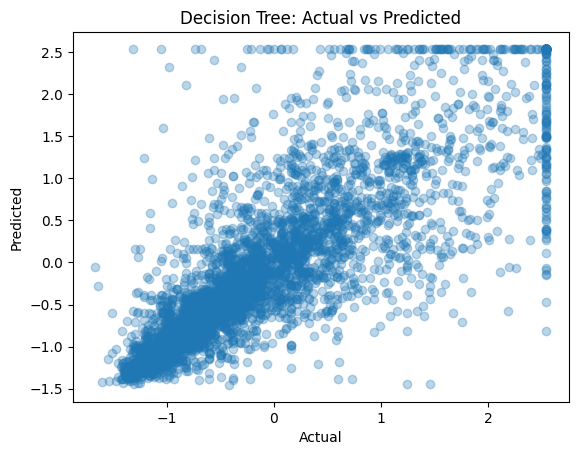


Random Forest Metrics
RMSE: 0.4303
MAE: 0.2779
R2: 0.8119


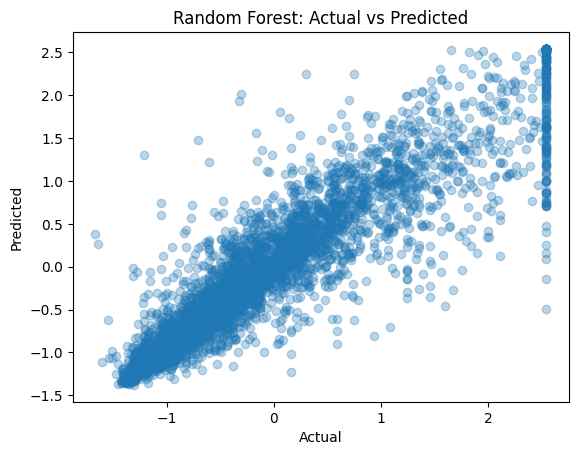

ValueError: All arrays must be of the same length

In [30]:
def main():
    X_train, X_test, y_train, y_test = load_data()
    preprocessor = build_preprocessor(X_train)
    models = get_models()

    for key, config in models.items():
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", config.model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        metrics = evaluate_model(y_test, y_pred)

        print(f"\n{config.name} Metrics")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")

        plot_actual_vs_pred(
            y_test,
            y_pred,
            f"{config.name}: Actual vs Predicted"
        )

        if key == "random_forest":
            plot_feature_importance(
                pipeline.named_steps["regressor"],
                X_train.columns
            )

    # Tuning example (Decision Tree)
    dt_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", DecisionTreeRegressor(random_state=RANDOM_STATE))
    ])

    tuned_dt, best_params = tune_decision_tree(
        dt_pipeline,
        X_train,
        y_train
    )

    print("\nBest Decision Tree Params:", best_params)


if __name__ == "__main__":
    main()
